Deep Learning
=============

Assignment 4
------------

Previously in `2_fullyconnected.ipynb` and `3_regularization.ipynb`, we trained fully connected networks to classify [notMNIST](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html) characters.

The goal of this assignment is make the neural network convolutional.

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
from six.moves import range

In [3]:
pickle_file = 'C://Users//GuptaG//Documents//ML//TF//udacity.ud730.deeplearning-master//assignments//notMNIST.pickle'

with open(pickle_file, 'rb') as f:
    save = pickle.load(f)
    train_dataset = save['train_dataset']
    train_labels = save['train_labels']
    valid_dataset = save['valid_dataset']
    valid_labels = save['valid_labels']
    test_dataset = save['test_dataset']
    test_labels = save['test_labels']
    del save  # hint to help gc free up memory
    print('Training set', train_dataset.shape, train_labels.shape)
    print('Validation set', valid_dataset.shape, valid_labels.shape)
    print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28) (200000,)
Validation set (10000, 28, 28) (10000,)
Test set (10000, 28, 28) (10000,)


Reformat into a TensorFlow-friendly shape:
- convolutions need the image data formatted as a cube (width by height by #channels)
- labels as float 1-hot encodings.

In [4]:
image_size = 28
num_labels = 10
num_channels = 1 # only grayscale as classifcation depend on shape rather than color

import numpy as np

def reformat(dataset, labels):
    dataset = dataset.reshape(
        (-1, image_size, image_size, num_channels)).astype(np.float32)
    labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
    return dataset, labels
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28, 1) (200000, 10)
Validation set (10000, 28, 28, 1) (10000, 10)
Test set (10000, 28, 28, 1) (10000, 10)


In [5]:
def accuracy(predictions, labels):
    return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

Let's build a small network with two convolutional layers, followed by one fully connected layer. Convolutional networks are more expensive computationally, so we'll limit its depth and number of fully connected nodes.

Neural Net will be CONV>>RELU>>CONV>>RELU>>FC>>RELU>>OUTPUT

In [43]:
batch_size = 16
patch_size = 5
depth = 16
num_hidden = 64

graph = tf.Graph()

with graph.as_default():

    # Input data.
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size, image_size, num_channels))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
  
    # Variables.
    layer1_weights = tf.Variable(tf.truncated_normal([patch_size, patch_size, num_channels, depth], stddev=0.1))
    layer1_biases = tf.Variable(tf.zeros([depth]))
    layer2_weights = tf.Variable(tf.truncated_normal([patch_size, patch_size, depth, depth], stddev=0.1))
    layer2_biases = tf.Variable(tf.constant(1.0, shape=[depth]))
    layer3_weights = tf.Variable(tf.truncated_normal(
        [image_size // 4 * image_size // 4 * depth, num_hidden], stddev=0.1))
    layer3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]))
    layer4_weights = tf.Variable(tf.truncated_normal(
      [num_hidden, num_labels], stddev=0.1))
    layer4_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))
  
    # Model.
    def model(data):
        #conv2d(input_image, width, length, channel)
        #for CNN first and last arguement is always one
        conv = tf.nn.conv2d(data, layer1_weights, [1, 2, 2, 1], padding='SAME')
        hidden = tf.nn.relu(conv + layer1_biases)
        conv = tf.nn.conv2d(hidden, layer2_weights, [1, 2, 2, 1], padding='SAME')
        hidden = tf.nn.relu(conv + layer2_biases)
        shape = hidden.get_shape().as_list()
        reshape = tf.reshape(hidden, [shape[0], shape[1] * shape[2] * shape[3]])
        hidden = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)
        return tf.matmul(hidden, layer4_weights) + layer4_biases
  
    # Training computation.
    logits = model(tf_train_dataset)
    loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits))

    # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(0.05).minimize(loss)

    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(model(tf_valid_dataset))
    test_prediction = tf.nn.softmax(model(tf_test_dataset))

In [ ]:
num_steps = 1501

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print('Initialized')
    for step in range(num_steps):
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run(
          [optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 50 == 0):
            print('Minibatch loss at step %d: %f' % (step, l))
            print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels))
            print('Validation accuracy: %.1f%%' % accuracy(valid_prediction.eval(), valid_labels))
            print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))

In [ ]:
print(image_size // 4 * image_size // 4 * depth)

---
Problem 1
---------

The convolutional model above uses convolutions with stride 2 to reduce the dimensionality. Replace the strides by a max pooling operation (`nn.max_pool()`) of stride 2 and kernel size 2.

---

In [48]:
batch_size = 16
patch_size = 5
depth = 16
num_hidden = 64
k = 2
graph = tf.Graph()

with graph.as_default():

  # Input data.
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size, image_size, num_channels))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)

    # Variables.
    layer1_weights = tf.Variable(tf.truncated_normal([patch_size, patch_size, num_channels, depth], stddev=0.1))
    layer1_biases = tf.Variable(tf.zeros([depth]))
    layer2_weights = tf.Variable(tf.truncated_normal([patch_size, patch_size, depth, depth], stddev=0.1))
    layer2_biases = tf.Variable(tf.constant(1.0, shape=[depth]))
    layer3_weights = tf.Variable(tf.truncated_normal([image_size // 4 * image_size // 4 * depth, num_hidden], stddev=0.1))
    layer3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]))
    layer4_weights = tf.Variable(tf.truncated_normal([num_hidden, num_labels], stddev=0.1))
    layer4_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))

    # Model.
    def model(data):
        conv = tf.nn.conv2d(data, layer1_weights, [1, 1, 1, 1], padding='SAME')
        hidden = tf.nn.relu(conv + layer1_biases)
        pool = tf.nn.max_pool(hidden, [1, k, k, 1], [1, k, k, 1], padding='SAME')
        conv = tf.nn.conv2d(pool, layer2_weights, [1, 1, 1, 1], padding='SAME')
        hidden = tf.nn.relu(conv + layer2_biases)
        pool = tf.nn.max_pool(hidden, [1, k, k, 1], [1, k, k, 1], padding='SAME')
        shape = pool.get_shape().as_list()
        reshape = tf.reshape(pool, [shape[0], shape[1] * shape[2] * shape[3]])
        hidden = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)
        return tf.matmul(hidden, layer4_weights) + layer4_biases

    # Training computation.
    logits = model(tf_train_dataset)
    loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels = tf_train_labels))

    # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(0.01).minimize(loss)

    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(model(tf_valid_dataset))
    test_prediction = tf.nn.softmax(model(tf_test_dataset))

In [49]:
num_steps = 2500

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print('Initialized')
    for step in range(num_steps):
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 50 == 0):
            print('Minibatch loss at step %d: %f' % (step, l))
            print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels))
            print('Validation accuracy: %.1f%%' % accuracy(valid_prediction.eval(), valid_labels))
            print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 3.495328
Minibatch accuracy: 12.5%
Validation accuracy: 7.2%
Test accuracy: 6.6%
Minibatch loss at step 50: 2.397137
Minibatch accuracy: 31.2%
Validation accuracy: 23.6%
Test accuracy: 25.5%
Minibatch loss at step 100: 1.679007
Minibatch accuracy: 56.2%
Validation accuracy: 41.7%
Test accuracy: 44.4%
Minibatch loss at step 150: 1.046049
Minibatch accuracy: 87.5%
Validation accuracy: 60.9%
Test accuracy: 66.7%
Minibatch loss at step 200: 1.210949
Minibatch accuracy: 68.8%
Validation accuracy: 67.9%
Test accuracy: 74.7%
Minibatch loss at step 250: 0.907836
Minibatch accuracy: 68.8%
Validation accuracy: 74.5%
Test accuracy: 81.2%
Minibatch loss at step 300: 0.960928
Minibatch accuracy: 62.5%
Validation accuracy: 73.8%
Test accuracy: 80.6%
Minibatch loss at step 350: 0.632563
Minibatch accuracy: 75.0%
Validation accuracy: 76.3%
Test accuracy: 83.5%
Minibatch loss at step 400: 0.786362
Minibatch accuracy: 75.0%
Validation accuracy: 75.2%
Test accuracy: 

---
Problem 2
---------

Try to get the best performance you can using a convolutional net. Look for example at the classic [LeNet5](http://yann.lecun.com/exdb/lenet/) architecture, adding Dropout, and/or adding learning rate decay.

---

Implementing CNN
Base archietechture is INPUT => CONV => RELU => POOL => CONV => RELU => POOL => FC => RELU => FC
With dropouts, learning rate decay, max pooling

In [19]:
batch_size = 16
patch_size = 5
depth = 16
num_hidden = 64
num_hidden2 = 64
k = 2
keep_prob = 0.7

graph = tf.Graph()

with graph.as_default():

    # Input data.
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size, image_size, num_channels))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    global_step = tf.Variable(0)
  
    # Variables.
    #Conv1 Layer 28X28
    layer1_weights = tf.Variable(tf.truncated_normal([patch_size, patch_size, num_channels, depth], stddev=0.1))
    layer1_biases = tf.Variable(tf.zeros([depth]))
    #Conv2 Layer 12x12
    layer2_weights = tf.Variable(tf.truncated_normal([patch_size, patch_size, depth, depth], stddev=0.1))
    layer2_biases = tf.Variable(tf.constant(1.0, shape=[depth]))
    #FC Layer one
    layer3_weights = tf.Variable(tf.truncated_normal([image_size//2*image_size//2*depth, num_hidden], stddev=0.1))
    layer3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]))
    
    layer4_weights = tf.Variable(tf.truncated_normal(
      [num_hidden, num_hidden2], stddev=0.1))
    layer4_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden2]))
    
    layer5_weights = tf.Variable(tf.truncated_normal([num_hidden,num_labels], stddev=0.1))
    layer5_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))
  
    # Model.
    def model(data):
        #conv2d(input_image, width, length, channel)
        #for CNN first and last arguement is always one
        conv = tf.nn.conv2d(data, layer1_weights, [1, 1, 1, 1], padding='SAME')
        conv = tf.add(conv, layer1_biases)
        #conv = tf.nn.dropout(conv,keep_prob=keep_prob)
        hidden = tf.nn.relu(conv)
        pool = tf.nn.max_pool(hidden,[1,k,k,1], [1,k,k,1],padding='SAME')
        
        
        conv = tf.nn.conv2d(pool, layer2_weights, [1, 1, 1, 1], padding='SAME')
        conv = tf.add(conv , layer2_biases)
        #conv = tf.nn.dropout(conv,keep_prob=keep_prob)
        hidden = tf.nn.relu(conv)
        pool = tf.nn.max_pool(hidden,[1,k,k,1], [1,k,k,1],padding='SAME')
        
        #FC1
        shape = hidden.get_shape().as_list()
        #print(shape)
        reshape = tf.reshape(hidden, [shape[0], shape[1] * shape[2] * shape[3]])
        reshape = tf.matmul(reshape,layer3_weights) + layer3_biases
        reshape = tf.nn.dropout(reshape, keep_prob=keep_prob)
        logits = tf.nn.relu(reshape)
        
        #FC2
        logits = tf.add(tf.matmul(logits, layer4_weights), layer4_biases)
        #logits = tf.nn.dropout(logits, keep_prob=keep_prob)
        logits = tf.nn.relu(logits)
        
        return tf.matmul(logits, layer5_weights) + layer5_biases
  
    # Training computation.
    logits = model(tf_train_dataset)
    loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits))

    # Optimizer.
    learning_rate = tf.train.exponential_decay(0.5,global_step,5000,0.65,staircase=True)
    optimizer = tf.train.GradientDescentOptimizer(0.05).minimize(loss)

    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(model(tf_valid_dataset))
    test_prediction = tf.nn.softmax(model(tf_test_dataset))

In [20]:
num_steps = 5000
loss_vec = []
test_result = []
with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print('Initialized')
    for step in range(num_steps):
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
        loss_vec.append(l)
        if (step % 50 == 0):
            print('Minibatch loss at step %d: %f' % (step, l))
            temp = accuracy(valid_prediction.eval(), valid_labels)
            print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels))
            print('Validation accuracy: %.1f%%' % temp)
            test_result.append(temp)
    print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 4.524436
Minibatch accuracy: 0.0%
Validation accuracy: 10.0%
Minibatch loss at step 50: 2.210018
Minibatch accuracy: 12.5%
Validation accuracy: 29.8%
Minibatch loss at step 100: 1.137686
Minibatch accuracy: 43.8%
Validation accuracy: 50.1%
Minibatch loss at step 150: 1.104823
Minibatch accuracy: 56.2%
Validation accuracy: 59.0%
Minibatch loss at step 200: 1.376611
Minibatch accuracy: 56.2%
Validation accuracy: 66.5%
Minibatch loss at step 250: 0.747553
Minibatch accuracy: 81.2%
Validation accuracy: 72.3%
Minibatch loss at step 300: 1.079746
Minibatch accuracy: 62.5%
Validation accuracy: 72.3%
Minibatch loss at step 350: 0.481948
Minibatch accuracy: 81.2%
Validation accuracy: 73.2%
Minibatch loss at step 400: 0.922088
Minibatch accuracy: 62.5%
Validation accuracy: 71.3%
Minibatch loss at step 450: 0.968533
Minibatch accuracy: 68.8%
Validation accuracy: 77.0%
Minibatch loss at step 500: 0.725326
Minibatch accuracy: 81.2%
Validation accuracy: 77.3%
Mi

Minibatch accuracy: 87.5%
Validation accuracy: 85.1%
Minibatch loss at step 4550: 0.235234
Minibatch accuracy: 100.0%
Validation accuracy: 85.2%
Minibatch loss at step 4600: 0.285661
Minibatch accuracy: 87.5%
Validation accuracy: 85.2%
Minibatch loss at step 4650: 0.402335
Minibatch accuracy: 87.5%
Validation accuracy: 85.6%
Minibatch loss at step 4700: 0.655910
Minibatch accuracy: 81.2%
Validation accuracy: 85.4%
Minibatch loss at step 4750: 0.133979
Minibatch accuracy: 100.0%
Validation accuracy: 85.5%
Minibatch loss at step 4800: 0.142668
Minibatch accuracy: 93.8%
Validation accuracy: 85.3%
Minibatch loss at step 4850: 1.090491
Minibatch accuracy: 81.2%
Validation accuracy: 85.2%
Minibatch loss at step 4900: 0.518578
Minibatch accuracy: 81.2%
Validation accuracy: 85.9%
Minibatch loss at step 4950: 0.549742
Minibatch accuracy: 81.2%
Validation accuracy: 85.2%
Test accuracy: 91.0%


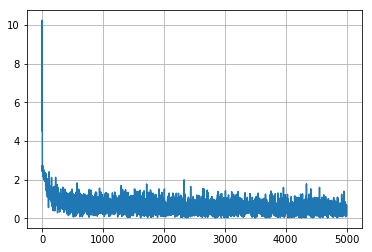

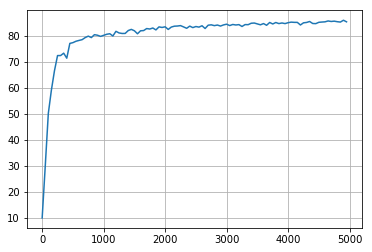

In [27]:
import matplotlib.pyplot as plt
%matplotlib inline
stps = np.arange(0,5000)
plt.plot(stps,loss_vec)
plt.grid(True)
plt.show()

stps = np.arange(0,5000,50)
plt.plot(stps,test_result)
plt.grid(True)
plt.show()